In [1]:
import numpy as np 
from matplotlib import pyplot as plt

In [ ]:
data_path = "pretraining_results/20250325_020022/data/pretraining_dataset.npy"
data = np.load(data_path)
print(data.shape)
obs_action_data = data[:, 0:9]
labels = ['T', 'H2', 'O2', 'H', 'OH', 'H2O', 'HO2', 'H2O2', 'action']

def reverse_temperature(T):
    return 10**(T*3)

def reverse_species(Y):
    return 10**(Y*20)
# reverse the data
reverse_data = obs_action_data.copy()
reverse_data[:, 0] = reverse_temperature(reverse_data[:, 0])
reverse_data[:, 1:-1] = reverse_species(reverse_data[:, 1:-1])

action = reverse_data[:, -1]

# COUNT THE NUMBER OF Action clases and the number of samples in each class
class_counts = np.bincount(action.astype(int))
print(class_counts)

# Create a 4x2 subplot figure
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# plot the temperature AND each species against the action, sort each data before plotting
for i, label in enumerate(labels[:-1]):
    # concatenate the i data with the action
    joined_data = np.column_stack((reverse_data[:, i], reverse_data[:, -1]))
    # sort the data by the action
    sorted_data = joined_data[joined_data[:, 0].argsort()]
    # plot the data
    axes[i].plot(sorted_data[:, 1], sorted_data[:, 0], 'o-')
    axes[i].set_xlabel(label)
    axes[i].set_ylabel('Action')
    axes[i].set_title(f"{label} vs Action")

plt.tight_layout()
plt.savefig('all_plots.png')
plt.show()

(71481, 14)


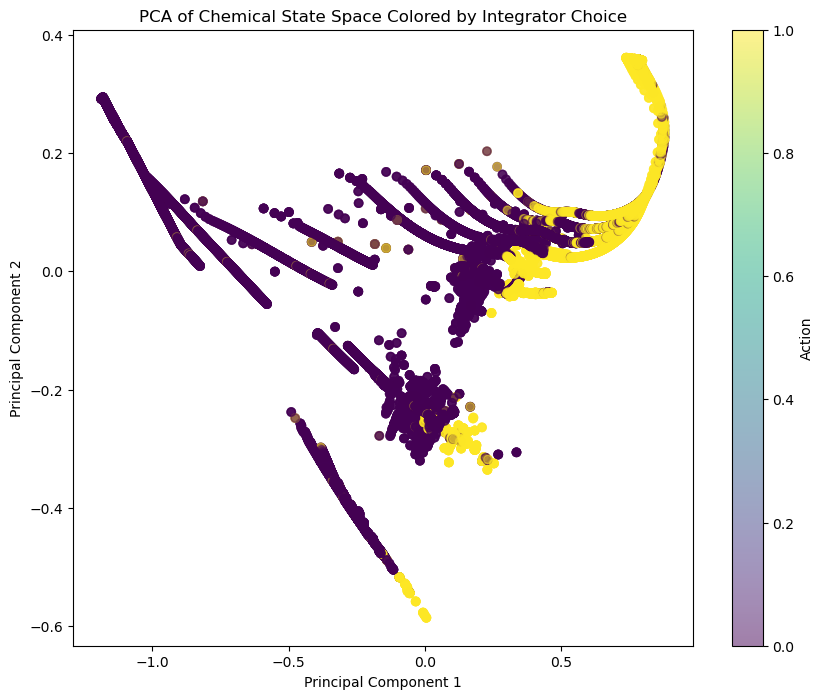

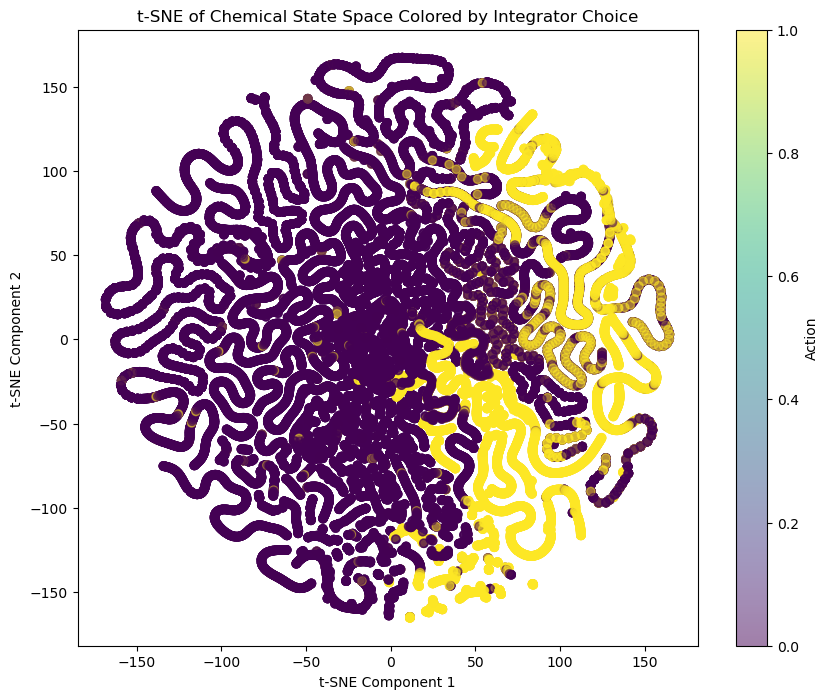

In [105]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Extract features and actions
features = data[:, :8]  # All features except action
actions = data[:, 8].astype(int)  # Actions

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

# Create plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=actions, cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Action')
plt.title('PCA of Chemical State Space Colored by Integrator Choice')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# For t-SNE (takes longer but can reveal more complex patterns)
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=actions, cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Action')
plt.title('t-SNE of Chemical State Space Colored by Integrator Choice')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

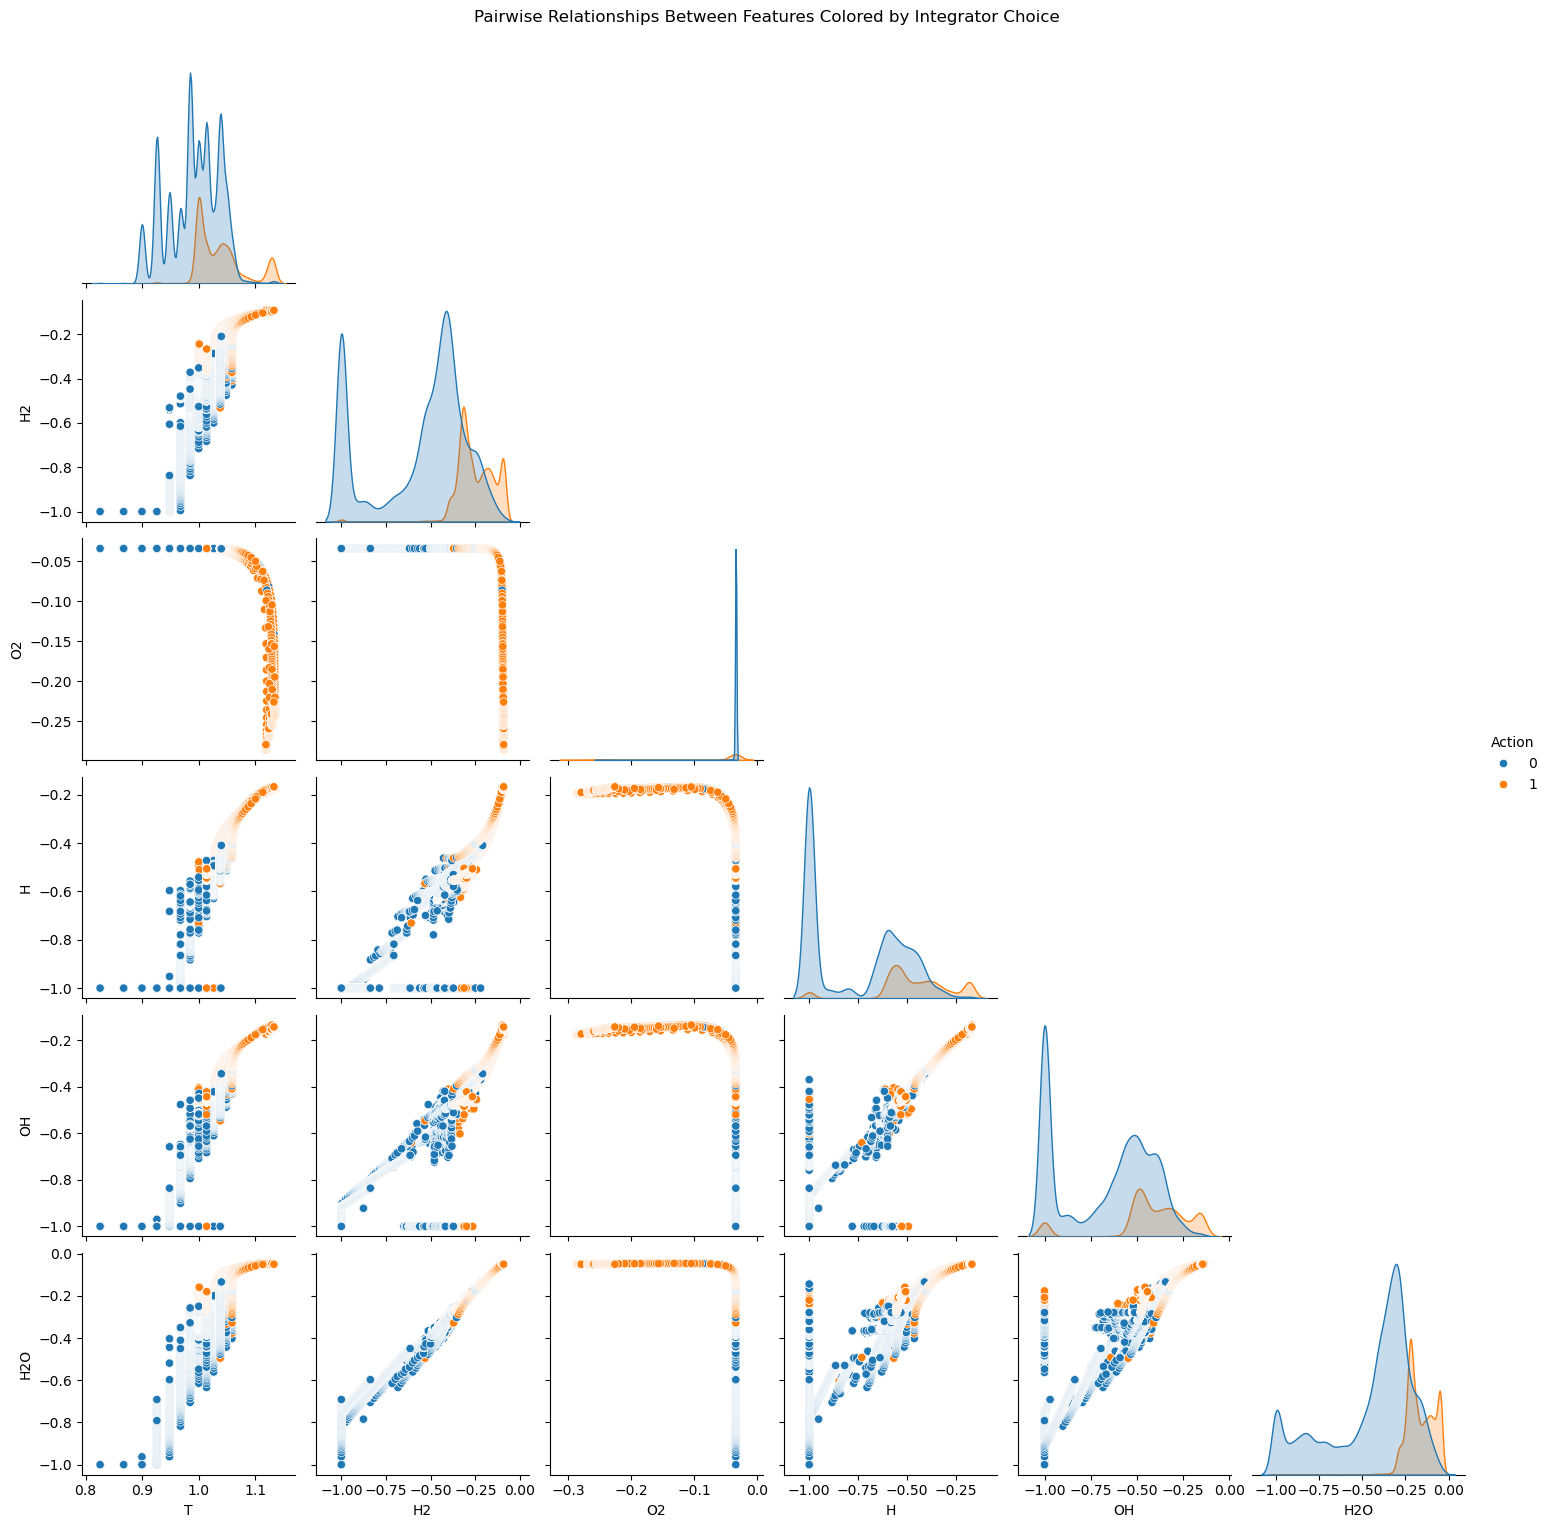

In [106]:
import seaborn as sns

# Select most important features
selected_features = ['T', 'H2', 'O2', 'H', 'OH', 'H2O']
indices = [0, 1, 2, 3, 4, 5]  # Corresponding indices

# Create a dataframe with selected features and action
import pandas as pd
df = pd.DataFrame(data[:, indices], columns=selected_features)
df['Action'] = data[:, 8].astype(int)

# Create pairplot
sns.pairplot(df, hue='Action', corner=True, diag_kind='kde')
plt.suptitle('Pairwise Relationships Between Features Colored by Integrator Choice', y=1.02)
plt.show()

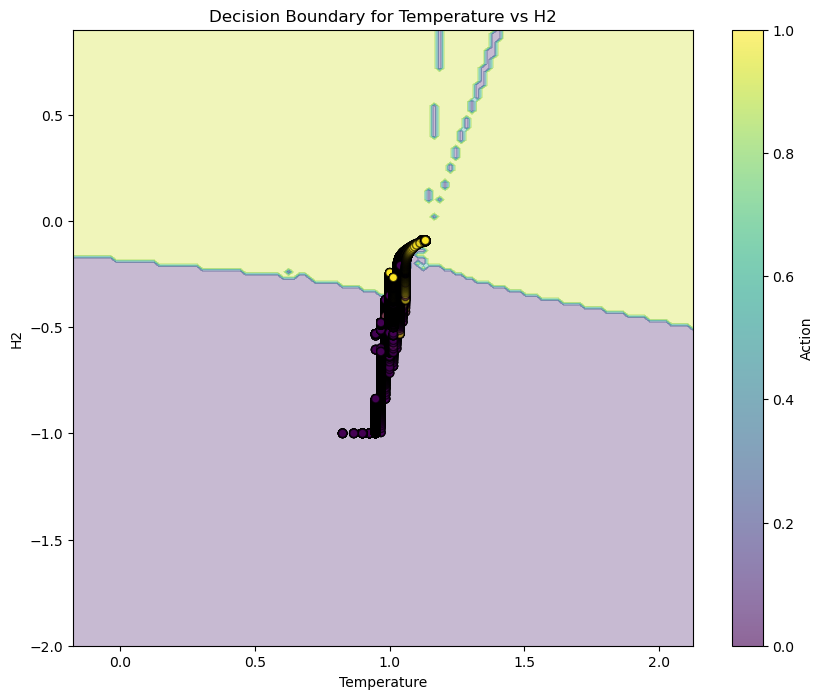

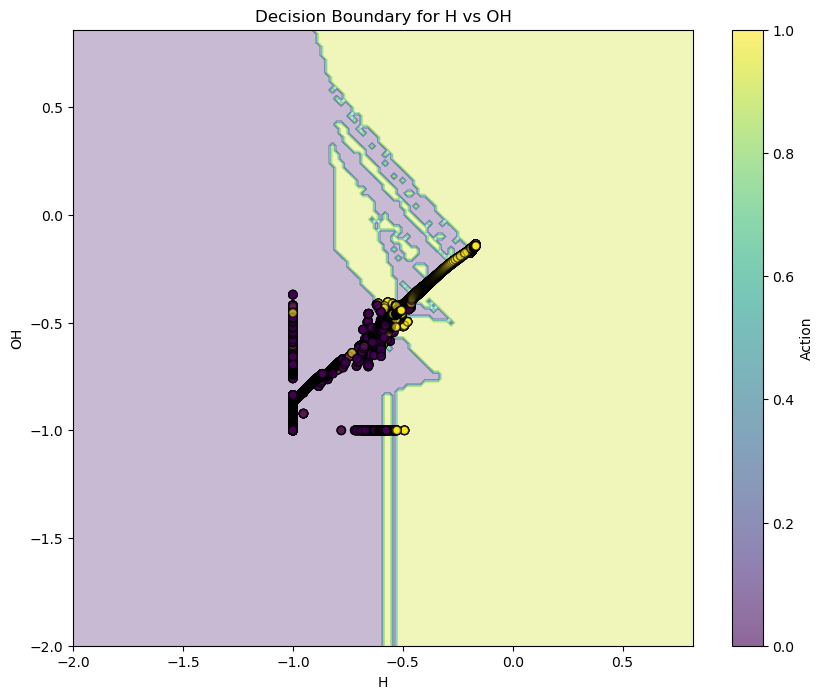

In [107]:

def plot_decision_boundary(feature1_idx, feature2_idx, feature_names):
    # Extract two features and the action
    X = data[:, [feature1_idx, feature2_idx]]
    y = data[:, 8].astype(int)
    
    # Create a mesh grid
    h = 0.02  # Step size
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Train a simple classifier
    from sklearn.neighbors import KNeighborsClassifier
    clf = KNeighborsClassifier(n_neighbors=15)
    clf.fit(X, y)
    
    # Predict on the mesh grid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    
    # Plot the data points
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', 
                         edgecolors='k', alpha=0.6)
    plt.colorbar(scatter, label='Action')
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title(f'Decision Boundary for {feature_names[0]} vs {feature_names[1]}')
    plt.show()

# Plot for temperature and H2
plot_decision_boundary(0, 1, ['Temperature', 'H2'])
# Plot for H and OH
plot_decision_boundary(3, 4, ['H', 'OH'])




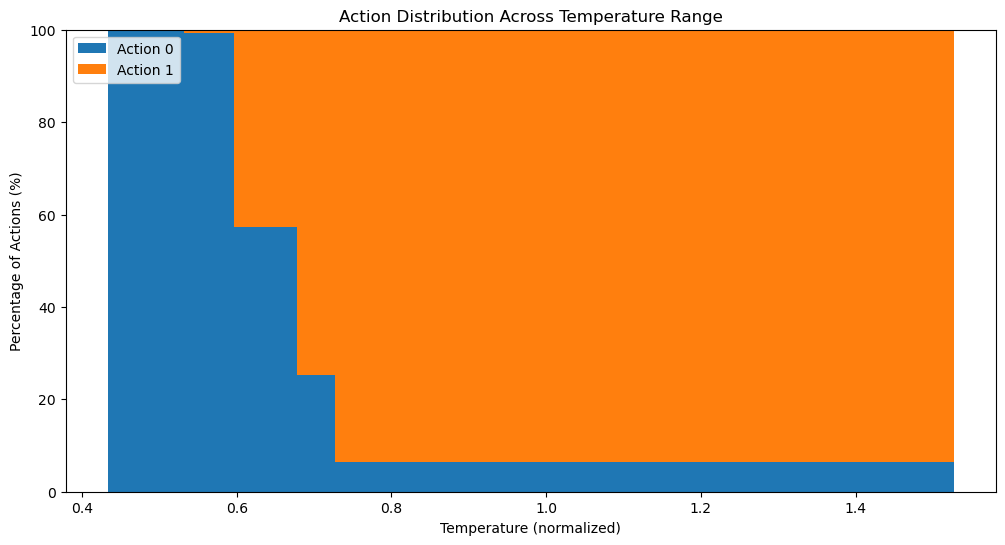

In [108]:
# Bin temperature values
temp_bins = np.linspace(data[:, 0].min(), data[:, 0].max(), 20)
binned_temps = np.digitize(data[:, 0], temp_bins)

# Count actions in each temperature bin
action_counts = {}
for bin_idx in range(1, len(temp_bins)+1):
    mask = (binned_temps == bin_idx)
    bin_actions = data[mask, 8].astype(int)
    unique, counts = np.unique(bin_actions, return_counts=True)
    action_counts[bin_idx] = dict(zip(unique, counts))

# Visualize the action distribution across temperature bins
plt.figure(figsize=(12, 6))
bin_centers = (temp_bins[:-1] + temp_bins[1:]) / 2

# Calculate percentages
action_percentages = {}
for bin_idx, counts in action_counts.items():
    total = sum(counts.values())
    if total > 0:
        action_percentages[bin_idx] = {action: count/total*100 for action, count in counts.items()}

# Plot stacked bar chart
actions = sorted(list({action for counts in action_counts.values() for action in counts.keys()}))
bottom = np.zeros(len(bin_centers))

for action in actions:
    heights = [action_percentages.get(bin_idx, {}).get(action, 0) for bin_idx in range(1, len(temp_bins))]
    plt.bar(bin_centers, heights, bottom=bottom, label=f'Action {action}')
    bottom += heights

plt.xlabel('Temperature (normalized)')
plt.ylabel('Percentage of Actions (%)')
plt.title('Action Distribution Across Temperature Range')
plt.legend()
plt.show()

## POLICY ANALYSIS

In [2]:
import json
from datetime import datetime
from config.default_config import Args
from agents.ppo_ import PPO
from environment.env_wrapper import EnvManager
import torch
import os
import matplotlib.pyplot as plt
import numpy as np

Device set to : NVIDIA GeForce RTX 3080


In [3]:
# Create environment and agent
env_args = Args()
env_args.timeout = 0.5
env_manager = EnvManager(env_args, create_envs=False)

fixed_temperature = 1200
fixed_pressure = 1
fixed_phi = 1
end_time = 0.1
fixed_dt = 0.0001



Creating a single environment with fixed parameters - T=1200, P=1, phi=1, dt=0.0001
Combustion problem initialized with T=1200, P=101325.0, phi=1 and timestep=0.0001


Computing reference solution: 100%|██████████| 1000/1000 [00:00<00:00, 7012.96it/s]

Reference solution computed in 0.15 seconds
Done setting up problem
Done setting up integrator
Done setting up environment


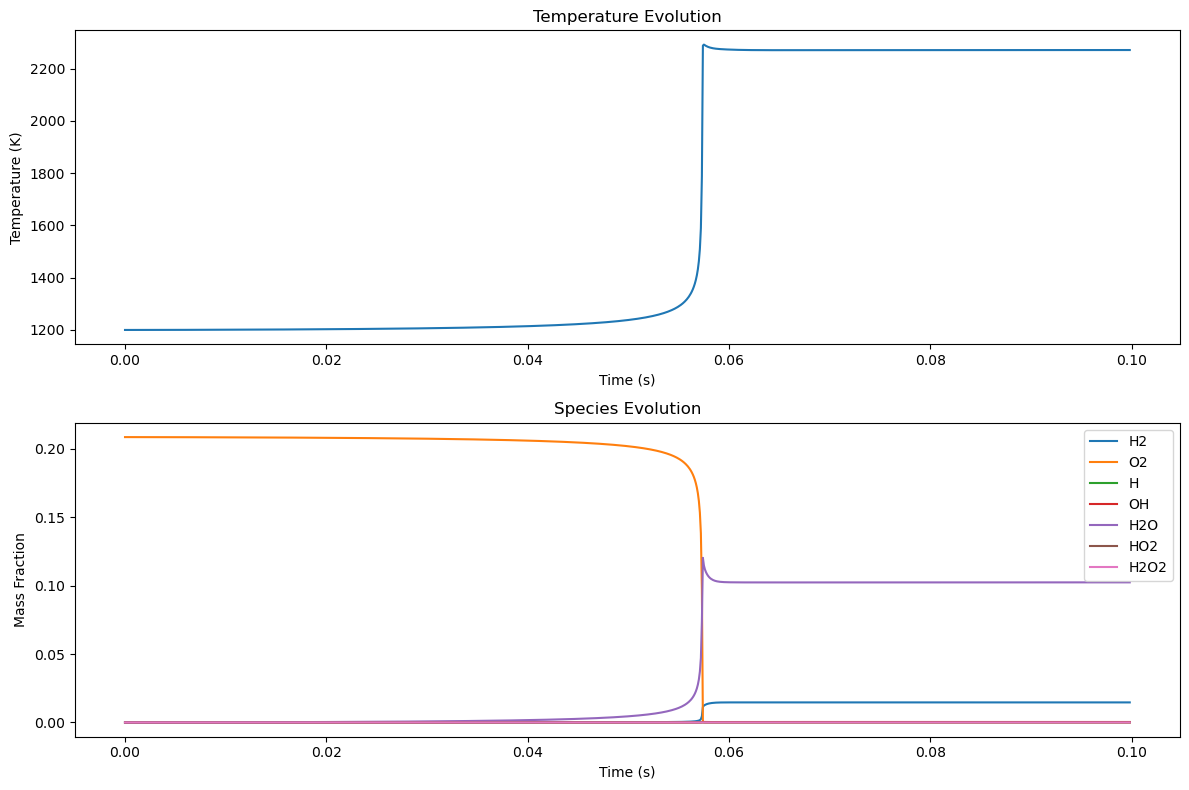

In [4]:
# Create a sample environment to get dimensions

env = env_manager.create_single_env(
    end_time=end_time,
    fixed_temperature=fixed_temperature,
    fixed_pressure=fixed_pressure,
    fixed_phi=fixed_phi,
    randomize=False,
    fixed_dt=fixed_dt
)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Initialize PPO agent
agent = PPO(
    state_dim=state_dim,
    action_dim=action_dim,
    lr_actor=env_args.learning_rate,
    lr_critic=env_args.learning_rate,
    gamma=0.99,
    K_epochs=10,
    eps_clip=0.2,
    has_continuous_action_space=False
)

# Set up device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
env.problem.plot_reference_solution()

In [5]:
 # Update policy_old with best weights
pretrained_model_path = "pretraining_results/20250325_120358/models/best_pretrained_actor.pth"
best_state_dict = torch.load(pretrained_model_path)

agent.policy.actor.load_state_dict(best_state_dict)
agent.policy_old.actor.load_state_dict(best_state_dict)


/tmp/ipykernel_694519/811845017.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_state_dict = torch.load(pretrained_model_path)


<All keys matched successfully>

In [30]:
obs, _ = env.reset()
done = False
episode_reward = 0
steps = 0
action_distribution = {}
stage_action_dist = {
    'PREIGNITION': {},
    'IGNITION': {},
    'POSTIGNITION': {}
}

# Track errors and CPU times for each integrator
integrator_metrics = {}
render=False
path="pretraining_results/20250325_020022/evaluation"
episode=0


action_list = env.integrator.action_list
for i in range(env.action_space.n):
    action_distribution[i] = action_distribution.get(i, 0)
    integrator_metrics[i] = integrator_metrics.get(i, {'errors': [], 'cpu_times': []})
    
    for stage in stage_action_dist:
        stage_action_dist[stage][i] = stage_action_dist[stage].get(i, 0)

while not done:
    # Use deterministic policy (argmax) for evaluation
    with torch.no_grad():
        action = agent.select_action(obs, deterministic=True)
    
    # Track action distribution
    action_distribution[action] += 1
    
    # Execute action
    obs, reward, terminated, truncated, info = env.step(1, timeout=env_args.timeout)
    done = terminated or truncated
    episode_reward += reward
    steps += 1
    
    # Track stage-specific action choices
    if 'current_stage' in info:
        stage = info['current_stage']
        if stage in stage_action_dist:
            stage_action_dist[stage][action] += 1
    
    # Track integrator-specific metrics
    if 'error' in info:
        integrator_metrics[action]['errors'].append(info['error'])
    if 'cpu_time' in info:
        integrator_metrics[action]['cpu_times'].append(info['cpu_time'])
    
if render:
    render_path = f"{path}/evaluation_episode_{episode+1}"
    os.makedirs(render_path, exist_ok=True)
    env.render(render_path)

State changed to IGNITION at step 495
State changed to POSTIGNITION at step 548


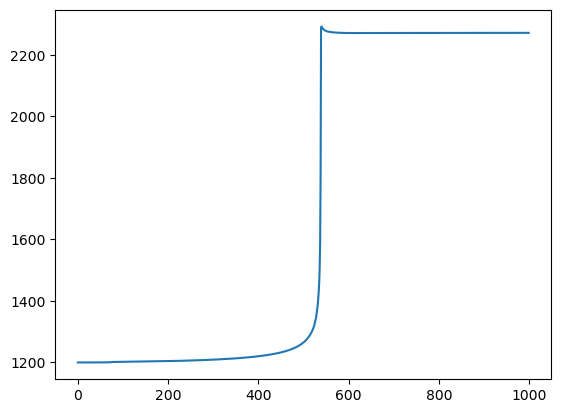

In [31]:
# plot the temperature history
plt.plot(env.integrator.history['temperatures'])
plt.show()

In [32]:
action_distribution

{0: 74, 1: 925}

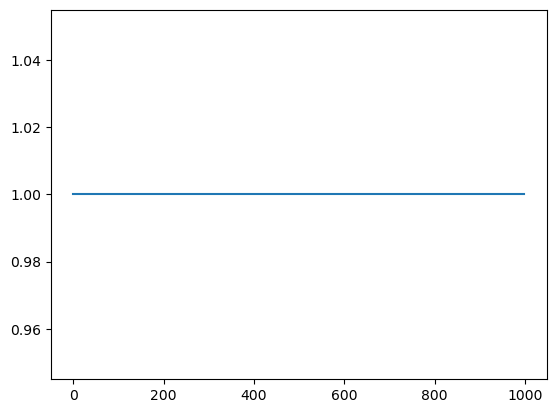

In [33]:
plt.plot(env.action_history)
plt.show()

In [6]:
import time
def compare_model_vs_fixed_actions(env_manager, agent, test_params=None, num_episodes=5, timeout=0.3, path="evaluation_results"):
    """
    Compare the trained model against fixed integrator actions.
    
    Args:
        env_manager: Environment manager
        agent: Trained PPO agent
        test_params: List of test parameter dicts, each containing temperature, pressure, phi, dt, end_time
                    If None, random parameters will be generated
        num_episodes: Number of episodes to evaluate (ignored if test_params is provided)
        timeout: Integration timeout
        path: Path to save results
    
    Returns:
        Dict of results for comparison
    """
    # Create directory for results
    os.makedirs(path, exist_ok=True)
    
    # Results storage
    results = {
        'model': {
            'rewards': [],
            'errors': [],
            'cpu_times': [],
            'action_distributions': [],
            'stage_distributions': []
        },
        'fixed_actions': {}
    }
    
    # Get number of possible actions from a sample environment
    sample_env = env_manager.create_single_env()
    num_actions = sample_env.action_space.n
    
    # Initialize results for fixed actions
    for action in range(num_actions):
        results['fixed_actions'][action] = {
            'rewards': [],
            'errors': [],
            'cpu_times': [],
            'stage_metrics': {}
        }
    
    # Use provided test parameters or generate random ones
    if test_params is None:
        test_params = []
        for episode in range(num_episodes):
            # Get random problem parameters
            temp = np.random.choice(env_manager.args.temperature_range)
            pressure = np.random.choice(env_manager.args.pressure_range)
            phi = np.random.choice(env_manager.args.phi_range)
            dt = np.random.choice(env_manager.args.min_time_steps_range if temp > 1000 else env_manager.args.max_time_steps_range)
            end_time = env_manager.args.end_time
            
            test_params.append({
                'temperature': temp,
                'pressure': pressure,
                'phi': phi,
                'dt': dt,
                'end_time': end_time
            })
    
    # Run episodes for each set of parameters
    for i, params in enumerate(test_params):
        print(f"\nTest case {i+1}/{len(test_params)}")
        print(f"Parameters: T={params['temperature']}K, P={params['pressure']}atm, " 
              f"phi={params['phi']}, dt={params['dt']}s, end_time={params['end_time']}s")
        
        # Run with model
        env_model = env_manager.create_single_env(
            fixed_temperature=params['temperature'],
            fixed_pressure=params['pressure'],
            fixed_phi=params['phi'],
            fixed_dt=params['dt'],
            end_time=params['end_time'],
            randomize=False
        )
        model_results = run_episode_with_tracking(
            env_model, agent, None, timeout, f"{path}/model_case_{i+1}"
        )
        results['model']['rewards'].append(model_results['reward'])
        results['model']['errors'].append(model_results['total_error'])
        results['model']['cpu_times'].append(model_results['total_cpu_time'])
        results['model']['action_distributions'].append(model_results['action_distribution'])
        results['model']['stage_distributions'].append(model_results['stage_distribution'])
        
        # Run with fixed actions
        for action in range(num_actions):
            env_fixed = env_manager.create_single_env(
                fixed_temperature=params['temperature'],
                fixed_pressure=params['pressure'],
                fixed_phi=params['phi'],
                fixed_dt=params['dt'],
                end_time=params['end_time'],
                randomize=False
            )
            fixed_results = run_episode_with_tracking(
                env_fixed, agent, action, timeout, f"{path}/fixed_{action}_case_{i+1}"
            )
            results['fixed_actions'][action]['rewards'].append(fixed_results['reward'])
            results['fixed_actions'][action]['errors'].append(fixed_results['total_error'])
            results['fixed_actions'][action]['cpu_times'].append(fixed_results['total_cpu_time'])
            
            # Store stage-specific metrics
            for stage, metrics in fixed_results['stage_metrics'].items():
                if stage not in results['fixed_actions'][action]['stage_metrics']:
                    results['fixed_actions'][action]['stage_metrics'][stage] = {
                        'cpu_times': [],
                        'errors': []
                    }
                
                if metrics['cpu_time'] is not None:
                    results['fixed_actions'][action]['stage_metrics'][stage]['cpu_times'].append(metrics['cpu_time'])
                
                if metrics['error'] is not None:
                    results['fixed_actions'][action]['stage_metrics'][stage]['errors'].append(metrics['error'])
        
        # Display progress
        print(f"Test case {i+1} completed:")
        print(f"  Model: Reward = {model_results['reward']:.2f}, CPU Time = {model_results['total_cpu_time']:.6f}s")
        for action in range(num_actions):
            print(f"  Fixed {action}: Reward = {results['fixed_actions'][action]['rewards'][-1]:.2f}, "
                  f"CPU Time = {results['fixed_actions'][action]['cpu_times'][-1]:.6f}s")
    
    # Calculate summary statistics
    summary = calculate_summary_statistics(results, num_actions)
    
    # Visualize results
    visualize_comparison_results(results, summary, path)
    
    return results, summary


def run_episode_with_tracking(env, agent, fixed_action, timeout, render_path=None):
    """
    Run a single episode with detailed tracking of metrics.
    
    Args:
        env: Environment instance
        agent: Trained agent
        fixed_action: If not None, use this fixed action instead of agent's policy
        timeout: Timeout for integration steps
        render_path: Path to save renders (if None, don't render)
        
    Returns:
        Dict of episode results
    """
    if fixed_action is not None:
        print(f"Running episode with fixed action {fixed_action}")
    else:
        print(f"Running episode with trained model")
    obs, _ = env.reset()
    done = False
    episode_reward = 0
    steps = 0
    action_distribution = {}
    stage_distribution = {
        'PREIGNITION': {},
        'IGNITION': {},
        'POSTIGNITION': {}
    }
    
    # Track metrics
    total_cpu_time = 0
    total_error = 0
    stage_metrics = {
        'PREIGNITION': {'cpu_time': 0, 'error': 0, 'steps': 0},
        'IGNITION': {'cpu_time': 0, 'error': 0, 'steps': 0},
        'POSTIGNITION': {'cpu_time': 0, 'error': 0, 'steps': 0}
    }
    current_stage = 'PREIGNITION'
    
    # Initialize action tracking
    for i in range(env.action_space.n):
        action_distribution[i] = 0
        for stage in stage_distribution:
            stage_distribution[stage][i] = 0
    

    counter = 0
    while not done:
        # Determine action
        if fixed_action is not None:
            action = fixed_action
        else:
            # Use deterministic policy from trained model
            with torch.no_grad():
                obs_tensor = torch.FloatTensor(obs).unsqueeze(0)
                action = agent.select_action(obs_tensor, deterministic=True)
                action = action.item() if hasattr(action, 'item') else action
        
        # Track action distribution
        action_distribution[action] += 1
        
        # Execute action
        next_obs, reward, terminated, truncated, info = env.step(action, timeout=timeout)
        done = terminated or truncated
        episode_reward += reward
        steps += 1
        
        # Update tracking metrics
        if 'cpu_time' in info:
            total_cpu_time += info['cpu_time']
        if 'error' in info:
            total_error += info['error']
        
        # Track stage-specific metrics
        if 'current_stage' in info:
            current_stage = info['current_stage']
            if current_stage in stage_distribution:
                stage_distribution[current_stage][action] += 1
                
                # Update stage metrics
                stage_metrics[current_stage]['steps'] += 1
                if 'cpu_time' in info:
                    stage_metrics[current_stage]['cpu_time'] += info['cpu_time']
                if 'error' in info:
                    stage_metrics[current_stage]['error'] += info['error']
        
        # Move to next observation
        obs = next_obs
        if counter % 10 == 0:
            print(f"Step {counter} of {steps} - Action Distribution: {action_distribution} - cpu time: {total_cpu_time} - error: {total_error} - max temperature: {max(env.integrator.history['temperatures'])}")
        counter += 1
    
    # Calculate average metrics per stage
    for stage in stage_metrics:
        if stage_metrics[stage]['steps'] > 0:
            stage_metrics[stage]['cpu_time'] /= stage_metrics[stage]['steps']
            stage_metrics[stage]['error'] /= stage_metrics[stage]['steps']
        else:
            stage_metrics[stage]['cpu_time'] = None
            stage_metrics[stage]['error'] = None
    
    # Render if requested
    if render_path is not None:
        # os.makedirs(render_path, exist_ok=True)
        env.render(render_path)
    
    return {
        'reward': episode_reward,
        'steps': steps,
        'action_distribution': action_distribution,
        'stage_distribution': stage_distribution,
        'total_cpu_time': total_cpu_time,
        'total_error': total_error,
        'stage_metrics': stage_metrics
    }


def calculate_summary_statistics(results, num_actions):
    """Calculate summary statistics from results."""
    summary = {
        'model': {
            'mean_reward': np.mean(results['model']['rewards']),
            'std_reward': np.std(results['model']['rewards']),
            'mean_cpu_time': np.mean(results['model']['cpu_times']),
            'mean_error': np.mean(results['model']['errors']),
            'action_usage': {}
        },
        'fixed_actions': {}
    }
    
    # Calculate action usage percentages for model
    all_actions = np.zeros(num_actions)
    for dist in results['model']['action_distributions']:
        for action, count in dist.items():
            all_actions[action] += count
    
    total_actions = np.sum(all_actions)
    for action in range(num_actions):
        if total_actions > 0:
            summary['model']['action_usage'][action] = all_actions[action] / total_actions * 100
        else:
            summary['model']['action_usage'][action] = 0
    
    # Calculate statistics for fixed actions
    for action in range(num_actions):
        summary['fixed_actions'][action] = {
            'mean_reward': np.mean(results['fixed_actions'][action]['rewards']),
            'std_reward': np.std(results['fixed_actions'][action]['rewards']),
            'mean_cpu_time': np.mean(results['fixed_actions'][action]['cpu_times']),
            'mean_error': np.mean(results['fixed_actions'][action]['errors']),
            'stage_metrics': {}
        }
        
        # Stage-specific metrics
        for stage, metrics in results['fixed_actions'][action]['stage_metrics'].items():
            cpu_times = [t for t in metrics['cpu_times'] if t is not None]
            errors = [e for e in metrics['errors'] if e is not None]
            
            summary['fixed_actions'][action]['stage_metrics'][stage] = {
                'mean_cpu_time': np.mean(cpu_times) if cpu_times else None,
                'mean_error': np.mean(errors) if errors else None
            }
    
    return summary


def visualize_comparison_results(results, summary, path):
    """Generate visualizations for comparing model vs fixed actions."""
    num_episodes = len(results['model']['rewards'])
    num_actions = len(results['fixed_actions'])
    
    # Create labels for plots
    labels = ['Model'] + [f'Action {a}' for a in range(num_actions)]
    
    # 1. Overall Performance Comparison
    plt.figure(figsize=(15, 5))
    
    # CPU Time comparison
    plt.subplot(1, 3, 1)
    times = [summary['model']['mean_cpu_time']] + [summary['fixed_actions'][a]['mean_cpu_time'] for a in range(num_actions)]
    plt.bar(labels, times)
    plt.title('Average CPU Time')
    plt.ylabel('Time (s)')
    plt.grid(axis='y', alpha=0.3)
    
    # Error comparison
    plt.subplot(1, 3, 2)
    errors = [summary['model']['mean_error']] + [summary['fixed_actions'][a]['mean_error'] for a in range(num_actions)]
    plt.bar(labels, errors)
    plt.title('Average Error')
    plt.grid(axis='y', alpha=0.3)
    
    # Reward comparison
    plt.subplot(1, 3, 3)
    rewards = [summary['model']['mean_reward']] + [summary['fixed_actions'][a]['mean_reward'] for a in range(num_actions)]
    plt.bar(labels, rewards)
    plt.title('Average Reward')
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{path}/overall_comparison.png')
    plt.close()
    
    # 2. Episode-by-episode comparison
    plt.figure(figsize=(15, 15))
    
    # Rewards
    plt.subplot(3, 1, 1)
    plt.plot(range(1, num_episodes+1), results['model']['rewards'], 'o-', label='Model')
    for action in range(num_actions):
        plt.plot(range(1, num_episodes+1), results['fixed_actions'][action]['rewards'], 'o-', label=f'Action {action}')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Rewards per Episode')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # CPU Times
    plt.subplot(3, 1, 2)
    plt.plot(range(1, num_episodes+1), results['model']['cpu_times'], 'o-', label='Model')
    for action in range(num_actions):
        plt.plot(range(1, num_episodes+1), results['fixed_actions'][action]['cpu_times'], 'o-', label=f'Action {action}')
    plt.xlabel('Episode')
    plt.ylabel('CPU Time (s)')
    plt.title('CPU Time per Episode')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Errors
    plt.subplot(3, 1, 3)
    plt.plot(range(1, num_episodes+1), results['model']['errors'], 'o-', label='Model')
    for action in range(num_actions):
        plt.plot(range(1, num_episodes+1), results['fixed_actions'][action]['errors'], 'o-', label=f'Action {action}')
    plt.xlabel('Episode')
    plt.ylabel('Error')
    plt.title('Error per Episode')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{path}/episode_comparison.png')
    plt.close()
    
    # 3. Model's Action Distribution
    action_usage = summary['model']['action_usage']
    plt.figure(figsize=(8, 6))
    plt.bar(range(num_actions), [action_usage.get(a, 0) for a in range(num_actions)])
    plt.xlabel('Action')
    plt.ylabel('Usage (%)')
    plt.title('Model Action Distribution')
    plt.xticks(range(num_actions), [f'Action {a}' for a in range(num_actions)])
    plt.grid(axis='y', alpha=0.3)
    plt.savefig(f'{path}/model_action_distribution.png')
    plt.close()
    
    # 4. Stage-specific Performance
    stages = ['PREIGNITION', 'IGNITION', 'POSTIGNITION']
    for stage in stages:
        plt.figure(figsize=(10, 5))
        
        # CPU Time
        plt.subplot(1, 2, 1)
        stage_times = []
        for action in range(num_actions):
            metrics = summary['fixed_actions'][action]['stage_metrics'].get(stage, {})
            stage_times.append(metrics.get('mean_cpu_time', 0) or 0)
        
        plt.bar(range(num_actions), stage_times)
        plt.xlabel('Action')
        plt.ylabel('CPU Time (s)')
        plt.title(f'Average CPU Time in {stage} Stage')
        plt.xticks(range(num_actions), [f'Action {a}' for a in range(num_actions)])
        plt.grid(axis='y', alpha=0.3)
        
        # Error
        plt.subplot(1, 2, 2)
        stage_errors = []
        for action in range(num_actions):
            metrics = summary['fixed_actions'][action]['stage_metrics'].get(stage, {})
            stage_errors.append(metrics.get('mean_error', 0) or 0)
        
        plt.bar(range(num_actions), stage_errors)
        plt.xlabel('Action')
        plt.ylabel('Error')
        plt.title(f'Average Error in {stage} Stage')
        plt.xticks(range(num_actions), [f'Action {a}' for a in range(num_actions)])
        plt.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'{path}/stage_{stage.lower()}_comparison.png')
        plt.close()

In [13]:
# Create output directory
# Define custom test parameters
custom_test_params = [
    # Pre-ignition case (low temperature)
    {
        'temperature': 800,
        'pressure': 1.0,
        'phi': 1.0,
        'dt': 1e-4,
        'end_time': 1e-2
    },
    #Ignition case (medium temperature)
    {
        'temperature': 1200,
        'pressure': 1.0,
        'phi': 1.0,
        'dt': 1e-5,
        'end_time': 1e-2
    },
    #Post-ignition case (high temperature)
    {
        'temperature': 2000,
        'pressure': 1.0,
        'phi': 1.0,
        'dt': 1e-6,
        'end_time': 1e-3
    },
    #Lean mixture case
    {
        'temperature': 1400,
        'pressure': 1.0,
        'phi': 0.6,
        'dt': 1e-6,
        'end_time': 1e-3
    },
    #Rich mixture case
    {
        'temperature': 1400,
        'pressure': 1.0,
        'phi': 1.4,
        'dt': 1e-5,
        'end_time': 1e-2
    }
]

# Create output directory
eval_path =f"pretraining_results/{time.strftime('%Y%m%d_%H%M%S')}/custom_evaluation"
os.makedirs(eval_path, exist_ok=True)

# Run the comparison analysis with custom parameters
results, summary = compare_model_vs_fixed_actions(
    env_manager=env_manager,
    agent=agent,
    test_params=custom_test_params,
    timeout=env_args.timeout,
    path=eval_path
)

# Print summary results
print("\n=== SUMMARY RESULTS ===")
print(f"Model Performance:")
print(f"  Average Reward: {summary['model']['mean_reward']:.2f}")
print(f"  Average CPU Time: {summary['model']['mean_cpu_time']:.6f} seconds")
print(f"  Average Error: {summary['model']['mean_error']:.6f}")
print(f"  Action Usage: {summary['model']['action_usage']}")

for action in range(len(summary['fixed_actions'])):
    print(f"\nFixed Action {action} Performance:")
    print(f"  Average Reward: {summary['fixed_actions'][action]['mean_reward']:.2f}")
    print(f"  Average CPU Time: {summary['fixed_actions'][action]['mean_cpu_time']:.6f} seconds")
    print(f"  Average Error: {summary['fixed_actions'][action]['mean_error']:.6f}")

Creating a single environment with random parameters
Combustion problem initialized with T=1500.0, P=101325.0, phi=1.0999999999999999 and timestep=1e-05


Computing reference solution: 100%|██████████| 100/100 [00:00<00:00, 3322.51it/s]


Reference solution computed in 0.03 seconds
Done setting up problem
Done setting up integrator
Done setting up environment

Test case 1/5
Parameters: T=800K, P=1.0atm, phi=1.0, dt=0.0001s, end_time=0.01s
Creating a single environment with fixed parameters - T=800, P=1.0, phi=1.0, dt=0.0001
Combustion problem initialized with T=800, P=101325.0, phi=1.0 and timestep=0.0001


Computing reference solution: 100%|██████████| 100/100 [00:00<00:00, 10652.74it/s]

Reference solution computed in 0.01 seconds
Done setting up problem
Done setting up integrator
Done setting up environment
Running episode with trained model
Predicted action: 0 - time: 0.0034601688385009766
Step 0 of 1 - Action Distribution: {0: 1, 1: 0} - cpu time: 0.00036025047302246094 - error: 1.2867484855405564e-13 - max temperature: 800.0
Predicted action: 0 - time: 0.002155780792236328
Predicted action: 0 - time: 0.0028748512268066406
Predicted action: 0 - time: 0.004366874694824219
Predicted action: 0 - time: 0.0037741661071777344
Predicted action: 0 - time: 0.0015435218811035156
Predicted action: 0 - time: 0.0012159347534179688
Predicted action: 0 - time: 0.0014319419860839844
Predicted action: 0 - time: 0.0062906742095947266
Predicted action: 0 - time: 0.0028297901153564453
Predicted action: 0 - time: 0.002363443374633789
Step 10 of 11 - Action Distribution: {0: 11, 1: 0} - cpu time: 0.0039827823638916016 - error: 2.5470479904199372e-05 - max temperature: 800.0023562805146
P

Predicted action: 0 - time: 0.0029311180114746094
Predicted action: 0 - time: 0.005690097808837891
Predicted action: 0 - time: 0.0034177303314208984
Step 30 of 31 - Action Distribution: {0: 31, 1: 0} - cpu time: 0.011567115783691406 - error: 9.403427516596619e-05 - max temperature: 800.0029329721648
Predicted action: 0 - time: 0.0037183761596679688
Predicted action: 0 - time: 0.008612394332885742
Predicted action: 0 - time: 0.0038895606994628906
Predicted action: 0 - time: 0.003438711166381836
Predicted action: 0 - time: 0.006456613540649414
Predicted action: 0 - time: 0.003455638885498047
Predicted action: 0 - time: 0.002640247344970703
Predicted action: 0 - time: 0.007238864898681641
Predicted action: 0 - time: 0.0028543472290039062
Predicted action: 0 - time: 0.003793954849243164
Step 40 of 41 - Action Distribution: {0: 41, 1: 0} - cpu time: 0.014620780944824219 - error: 0.00013236220983625646 - max temperature: 800.0031672111445
Predicted action: 0 - time: 0.005836009979248047
Pred

Computing reference solution: 100%|██████████| 100/100 [00:00<00:00, 11633.39it/s]

Reference solution computed in 0.01 seconds
Done setting up problem
Done setting up integrator
Done setting up environment
Running episode with fixed action 0
Step 0 of 1 - Action Distribution: {0: 1, 1: 0} - cpu time: 0.0002486705780029297 - error: 1.2867484855405564e-13 - max temperature: 800.0
Step 10 of 11 - Action Distribution: {0: 11, 1: 0} - cpu time: 0.0036668777465820312 - error: 2.5470479904199372e-05 - max temperature: 800.0023562805146
Step 20 of 21 - Action Distribution: {0: 21, 1: 0} - cpu time: 0.006269693374633789 - error: 5.831840985870418e-05 - max temperature: 800.0027373107145
Step 30 of 31 - Action Distribution: {0: 31, 1: 0} - cpu time: 0.009580373764038086 - error: 9.403427516596619e-05 - max temperature: 800.0029329721648
Step 40 of 41 - Action Distribution: {0: 41, 1: 0} - cpu time: 0.011383771896362305 - error: 0.00013236220983625646 - max temperature: 800.0031672111445
Step 50 of 51 - Action Distribution: {0: 51, 1: 0} - cpu time: 0.014510631561279297 - error

Creating a single environment with fixed parameters - T=800, P=1.0, phi=1.0, dt=0.0001
Combustion problem initialized with T=800, P=101325.0, phi=1.0 and timestep=0.0001


Computing reference solution: 100%|██████████| 100/100 [00:00<00:00, 13185.90it/s]

Reference solution computed in 0.01 seconds
Done setting up problem
Done setting up integrator
Done setting up environment
Running episode with fixed action 1
Step 0 of 1 - Action Distribution: {0: 0, 1: 1} - cpu time: 0.001203298568725586 - error: 4.551914400963142e-14 - max temperature: 800.0
Step 10 of 11 - Action Distribution: {0: 0, 1: 11} - cpu time: 0.013054132461547852 - error: 1.1218466000606497e-07 - max temperature: 800.0000127159313
Step 20 of 21 - Action Distribution: {0: 0, 1: 21} - cpu time: 0.0319209098815918 - error: 2.740952171897959e-07 - max temperature: 800.0000128703978
Step 30 of 31 - Action Distribution: {0: 0, 1: 31} - cpu time: 0.04541492462158203 - error: 4.390383239183393e-07 - max temperature: 800.0000130220839
Step 40 of 41 - Action Distribution: {0: 0, 1: 41} - cpu time: 0.05924224853515625 - error: 6.069757563231803e-07 - max temperature: 800.0000131749559
Step 50 of 51 - Action Distribution: {0: 0, 1: 51} - cpu time: 0.07348012924194336 - error: 7.77891

Test case 1 completed:
  Model: Reward = 88.94, CPU Time = 0.033887s
  Fixed 0: Reward = 89.83, CPU Time = 0.024292s
  Fixed 1: Reward = 79.02, CPU Time = 0.140557s

Test case 2/5
Parameters: T=1200K, P=1.0atm, phi=1.0, dt=1e-05s, end_time=0.01s
Creating a single environment with fixed parameters - T=1200, P=1.0, phi=1.0, dt=1e-05
Combustion problem initialized with T=1200, P=101325.0, phi=1.0 and timestep=1e-05


Computing reference solution: 100%|██████████| 999/999 [00:00<00:00, 13040.79it/s]

Reference solution computed in 0.08 seconds
Done setting up problem
Done setting up integrator
Done setting up environment
Running episode with trained model
Predicted action: 0 - time: 0.002821683883666992
Step 0 of 1 - Action Distribution: {0: 1, 1: 0} - cpu time: 0.0002753734588623047 - error: 5.8152755944007595e-09 - max temperature: 1200.0
Predicted action: 0 - time: 0.0018184185028076172
Predicted action: 0 - time: 0.0027332305908203125
Predicted action: 0 - time: 0.002303600311279297
Predicted action: 0 - time: 0.006821632385253906
Predicted action: 0 - time: 0.0029764175415039062
Predicted action: 0 - time: 0.002734661102294922
Predicted action: 0 - time: 0.0022706985473632812
Predicted action: 0 - time: 0.006440639495849609
Predicted action: 0 - time: 0.0031065940856933594
Predicted action: 0 - time: 0.0026268959045410156
Step 10 of 11 - Action Distribution: {0: 11, 1: 0} - cpu time: 0.003765583038330078 - error: 7.315190515444492e-06 - max temperature: 1200.0006814607855
Pred

Predicted action: 0 - time: 0.003267049789428711
Predicted action: 0 - time: 0.002367258071899414
Predicted action: 0 - time: 0.002113819122314453
Predicted action: 0 - time: 0.0016183853149414062
Predicted action: 0 - time: 0.0017540454864501953
Predicted action: 0 - time: 0.004145145416259766
Predicted action: 0 - time: 0.002527475357055664
Predicted action: 0 - time: 0.0026886463165283203
Predicted action: 0 - time: 0.0021255016326904297
Step 40 of 41 - Action Distribution: {0: 41, 1: 0} - cpu time: 0.012753009796142578 - error: 4.9887550301552785e-05 - max temperature: 1200.0006814607855
Predicted action: 0 - time: 0.001682281494140625
Predicted action: 0 - time: 0.002856016159057617
Predicted action: 0 - time: 0.002347707748413086
Predicted action: 0 - time: 0.002876758575439453
Predicted action: 0 - time: 0.0023965835571289062
Predicted action: 0 - time: 0.0026082992553710938
Predicted action: 0 - time: 0.0019178390502929688
Predicted action: 0 - time: 0.0015387535095214844
Predi

Computing reference solution: 100%|██████████| 999/999 [00:00<00:00, 13891.88it/s]

Reference solution computed in 0.07 seconds
Done setting up problem
Done setting up integrator
Done setting up environment
Running episode with fixed action 0
Step 0 of 1 - Action Distribution: {0: 1, 1: 0} - cpu time: 0.0002551078796386719 - error: 5.8152755944007595e-09 - max temperature: 1200.0
Step 10 of 11 - Action Distribution: {0: 11, 1: 0} - cpu time: 0.0026886463165283203 - error: 7.315190515444492e-06 - max temperature: 1200.0006814607855
Step 20 of 21 - Action Distribution: {0: 21, 1: 0} - cpu time: 0.004538536071777344 - error: 1.8431503445048847e-05 - max temperature: 1200.0006814607855
Step 30 of 31 - Action Distribution: {0: 31, 1: 0} - cpu time: 0.008131980895996094 - error: 3.369628880534048e-05 - max temperature: 1200.0006814607855
Step 40 of 41 - Action Distribution: {0: 41, 1: 0} - cpu time: 0.010233402252197266 - error: 4.9887550301552785e-05 - max temperature: 1200.0006814607855
Step 50 of 51 - Action Distribution: {0: 51, 1: 0} - cpu time: 0.01271510124206543 - e

Step 220 of 221 - Action Distribution: {0: 221, 1: 0} - cpu time: 0.06847262382507324 - error: 0.0010697695881772828 - max temperature: 1200.0588172189275
Step 230 of 231 - Action Distribution: {0: 231, 1: 0} - cpu time: 0.07225346565246582 - error: 0.0011623865587088167 - max temperature: 1200.065628177422
Step 240 of 241 - Action Distribution: {0: 241, 1: 0} - cpu time: 0.07653164863586426 - error: 0.0012558566875652266 - max temperature: 1200.0721492616717
Step 250 of 251 - Action Distribution: {0: 251, 1: 0} - cpu time: 0.0809323787689209 - error: 0.0013507820781445412 - max temperature: 1200.0794437671586
Step 260 of 261 - Action Distribution: {0: 261, 1: 0} - cpu time: 0.08501672744750977 - error: 0.0014471177178759786 - max temperature: 1200.0862744925876
Step 270 of 271 - Action Distribution: {0: 271, 1: 0} - cpu time: 0.0902719497680664 - error: 0.0015442334903067456 - max temperature: 1200.0937081718057
Step 280 of 281 - Action Distribution: {0: 281, 1: 0} - cpu time: 0.09441

Computing reference solution: 100%|██████████| 999/999 [00:00<00:00, 14330.70it/s]

Reference solution computed in 0.07 seconds
Done setting up problem
Done setting up integrator
Done setting up environment
Running episode with fixed action 1
Step 0 of 1 - Action Distribution: {0: 0, 1: 1} - cpu time: 0.002268552780151367 - error: 1.130948446004254e-09 - max temperature: 1200.0
Step 10 of 11 - Action Distribution: {0: 0, 1: 11} - cpu time: 0.022805213928222656 - error: 5.983288756672422e-07 - max temperature: 1200.0
Step 20 of 21 - Action Distribution: {0: 0, 1: 21} - cpu time: 0.0530092716217041 - error: 1.5982193469765704e-06 - max temperature: 1200.0
Step 30 of 31 - Action Distribution: {0: 0, 1: 31} - cpu time: 0.07520127296447754 - error: 2.947629077376668e-06 - max temperature: 1200.0
Step 40 of 41 - Action Distribution: {0: 0, 1: 41} - cpu time: 0.09899115562438965 - error: 4.490674678225837e-06 - max temperature: 1200.0


Step 50 of 51 - Action Distribution: {0: 0, 1: 51} - cpu time: 0.11867094039916992 - error: 6.451706934473833e-06 - max temperature: 1200.0
Step 60 of 61 - Action Distribution: {0: 0, 1: 61} - cpu time: 0.13333988189697266 - error: 8.860873300986505e-06 - max temperature: 1200.0
Step 70 of 71 - Action Distribution: {0: 0, 1: 71} - cpu time: 0.1557145118713379 - error: 1.1687520019676434e-05 - max temperature: 1200.0
Step 80 of 81 - Action Distribution: {0: 0, 1: 81} - cpu time: 0.173844575881958 - error: 1.5122986025239982e-05 - max temperature: 1200.0
Step 90 of 91 - Action Distribution: {0: 0, 1: 91} - cpu time: 0.18811631202697754 - error: 1.8979739231483883e-05 - max temperature: 1200.0
Step 100 of 101 - Action Distribution: {0: 0, 1: 101} - cpu time: 0.20101237297058105 - error: 2.3374483438476368e-05 - max temperature: 1200.0
Step 110 of 111 - Action Distribution: {0: 0, 1: 111} - cpu time: 0.215606689453125 - error: 2.826934491351185e-05 - max temperature: 1200.0016638846353
Ste

Computing reference solution:  22%|██▏       | 217/1000 [00:00<00:00, 3549.34it/s]

Reference solution computed in 0.06 seconds
Done setting up problem
Done setting up integrator
Done setting up environment
Running episode with trained model
Predicted action: 0 - time: 0.003481626510620117
Step 0 of 1 - Action Distribution: {0: 1, 1: 0} - cpu time: 0.0011222362518310547 - error: 2.0888934793017455e-07 - max temperature: 2000.0
Predicted action: 0 - time: 0.006494760513305664
Predicted action: 0 - time: 0.0030794143676757812
Predicted action: 0 - time: 0.0021643638610839844
Predicted action: 0 - time: 0.006246328353881836
Predicted action: 0 - time: 0.0027146339416503906
Predicted action: 0 - time: 0.005350351333618164
Predicted action: 0 - time: 0.0033385753631591797
Predicted action: 0 - time: 0.002493143081665039
Predicted action: 0 - time: 0.0036368370056152344
Predicted action: 0 - time: 0.0030930042266845703
Step 10 of 11 - Action Distribution: {0: 11, 1: 0} - cpu time: 0.0265200138092041 - error: 4.984293379806104e-06 - max temperature: 2000.0
Predicted action: 

Predicted action: 0 - time: 0.0033597946166992188
Predicted action: 0 - time: 0.003875255584716797
Predicted action: 0 - time: 0.003315448760986328
Predicted action: 0 - time: 0.003351926803588867
Step 20 of 21 - Action Distribution: {0: 21, 1: 0} - cpu time: 0.08233141899108887 - error: 1.7540866967702406e-05 - max temperature: 2011.6049955878414
Predicted action: 0 - time: 0.0033271312713623047
Predicted action: 0 - time: 0.005827665328979492
Predicted action: 0 - time: 0.003373384475708008
Predicted action: 0 - time: 0.0033216476440429688
Predicted action: 0 - time: 0.0032625198364257812
Predicted action: 0 - time: 0.0033843517303466797
Predicted action: 0 - time: 0.0026712417602539062
Predicted action: 0 - time: 0.005529642105102539
Predicted action: 0 - time: 0.003503561019897461
Predicted action: 0 - time: 0.00360870361328125
Step 30 of 31 - Action Distribution: {0: 31, 1: 0} - cpu time: 0.12446784973144531 - error: 7.4456101016529e-05 - max temperature: 2146.018988237915
Predict

Computing reference solution:  22%|██▏       | 217/1000 [00:00<00:00, 3456.91it/s]

Reference solution computed in 0.07 seconds
Done setting up problem
Done setting up integrator
Done setting up environment
Running episode with fixed action 0
Step 0 of 1 - Action Distribution: {0: 1, 1: 0} - cpu time: 0.001458883285522461 - error: 2.0888934793017455e-07 - max temperature: 2000.0
Step 10 of 11 - Action Distribution: {0: 11, 1: 0} - cpu time: 0.032210588455200195 - error: 4.984293379806104e-06 - max temperature: 2000.0
State changed to IGNITION at step 16
Step 20 of 21 - Action Distribution: {0: 21, 1: 0} - cpu time: 0.07894182205200195 - error: 1.7540866967702406e-05 - max temperature: 2011.6049955878414
Step 30 of 31 - Action Distribution: {0: 31, 1: 0} - cpu time: 0.12102270126342773 - error: 7.4456101016529e-05 - max temperature: 2146.018988237915


Step 40 of 41 - Action Distribution: {0: 41, 1: 0} - cpu time: 0.18142175674438477 - error: 0.0002980269112570211 - max temperature: 2702.032903059722
Step 50 of 51 - Action Distribution: {0: 51, 1: 0} - cpu time: 0.3111579418182373 - error: 0.0003688940062832602 - max temperature: 2928.5765446805235
State changed to POSTIGNITION at step 54
Step 60 of 61 - Action Distribution: {0: 61, 1: 0} - cpu time: 0.4299123287200928 - error: 0.00037077715078115414 - max temperature: 2932.7188436215165
Step 70 of 71 - Action Distribution: {0: 71, 1: 0} - cpu time: 0.539926290512085 - error: 0.0003724454368080332 - max temperature: 2932.7188436215165
Step 80 of 81 - Action Distribution: {0: 81, 1: 0} - cpu time: 0.6658506393432617 - error: 0.0003746291840550642 - max temperature: 2932.7188436215165
Step 90 of 91 - Action Distribution: {0: 91, 1: 0} - cpu time: 0.7953832149505615 - error: 0.0003768190790395254 - max temperature: 2932.7188436215165
Step 100 of 101 - Action Distribution: {0: 101, 1: 0}

Computing reference solution:  22%|██▏       | 217/1000 [00:00<00:00, 3356.20it/s]

Reference solution computed in 0.07 seconds
Done setting up problem
Done setting up integrator
Done setting up environment
Running episode with fixed action 1
Step 0 of 1 - Action Distribution: {0: 0, 1: 1} - cpu time: 0.002701282501220703 - error: 2.068244901209937e-05 - max temperature: 2000.0
Step 10 of 11 - Action Distribution: {0: 0, 1: 11} - cpu time: 0.01861095428466797 - error: 0.00021009177173025861 - max temperature: 2000.0
State changed to IGNITION at step 16
Step 20 of 21 - Action Distribution: {0: 0, 1: 21} - cpu time: 0.0381932258605957 - error: 0.0003572325221050665 - max temperature: 2011.5751095551695
Step 30 of 31 - Action Distribution: {0: 0, 1: 31} - cpu time: 0.05872631072998047 - error: 0.0005053437028244012 - max temperature: 2145.958930587704
Step 40 of 41 - Action Distribution: {0: 0, 1: 41} - cpu time: 0.07920694351196289 - error: 0.0008853090259708374 - max temperature: 2701.8384329286387
Step 50 of 51 - Action Distribution: {0: 0, 1: 51} - cpu time: 0.099350

Step 60 of 61 - Action Distribution: {0: 0, 1: 61} - cpu time: 0.11611795425415039 - error: 0.0012916084500769198 - max temperature: 2932.6911895902304
Step 70 of 71 - Action Distribution: {0: 0, 1: 71} - cpu time: 0.1313014030456543 - error: 0.001417013168625747 - max temperature: 2932.6911895902304
Step 80 of 81 - Action Distribution: {0: 0, 1: 81} - cpu time: 0.14670228958129883 - error: 0.0015302696778156655 - max temperature: 2932.6911895902304
Step 90 of 91 - Action Distribution: {0: 0, 1: 91} - cpu time: 0.16074728965759277 - error: 0.0016083475928228008 - max temperature: 2932.6911895902304
Step 100 of 101 - Action Distribution: {0: 0, 1: 101} - cpu time: 0.17450308799743652 - error: 0.0016488558347242943 - max temperature: 2932.6911895902304
Stopping simulation at step 109
Test case 3 completed:
  Model: Reward = 68.02, CPU Time = 0.270477s
  Fixed 0: Reward = -2.97, CPU Time = 1.038484s
  Fixed 1: Reward = 38.11, CPU Time = 0.186687s

Test case 4/5
Parameters: T=1400K, P=1.0a

Computing reference solution: 100%|██████████| 1000/1000 [00:00<00:00, 13943.60it/s]

Reference solution computed in 0.07 seconds
Done setting up problem
Done setting up integrator
Done setting up environment
Running episode with trained model
Predicted action: 0 - time: 0.004056215286254883
Step 0 of 1 - Action Distribution: {0: 1, 1: 0} - cpu time: 0.00026702880859375 - error: 2.632529860768784e-09 - max temperature: 1400.0
Predicted action: 0 - time: 0.0054323673248291016
Predicted action: 0 - time: 0.002922534942626953
Predicted action: 0 - time: 0.003424406051635742
Predicted action: 0 - time: 0.0033936500549316406
Predicted action: 0 - time: 0.003933429718017578
Predicted action: 0 - time: 0.0023810863494873047
Predicted action: 0 - time: 0.001962900161743164
Predicted action: 0 - time: 0.003323078155517578
Predicted action: 0 - time: 0.004923582077026367
Predicted action: 0 - time: 0.0031158924102783203
Step 10 of 11 - Action Distribution: {0: 11, 1: 0} - cpu time: 0.003907918930053711 - error: 3.1833254920954346e-08 - max temperature: 1400.0
Predicted action: 0 

Predicted action: 0 - time: 0.004509925842285156
Predicted action: 0 - time: 0.003573179244995117
Predicted action: 0 - time: 0.0028035640716552734
Step 30 of 31 - Action Distribution: {0: 31, 1: 0} - cpu time: 0.009743213653564453 - error: 2.274853522221676e-07 - max temperature: 1400.0
Predicted action: 0 - time: 0.003494739532470703
Predicted action: 0 - time: 0.004120588302612305
Predicted action: 0 - time: 0.003536701202392578
Predicted action: 0 - time: 0.0018107891082763672
Predicted action: 0 - time: 0.003175020217895508
Predicted action: 0 - time: 0.004361629486083984
Predicted action: 0 - time: 0.002189159393310547
Predicted action: 0 - time: 0.001519918441772461
Predicted action: 0 - time: 0.0013110637664794922
Predicted action: 0 - time: 0.0014088153839111328
Step 40 of 41 - Action Distribution: {0: 41, 1: 0} - cpu time: 0.013787269592285156 - error: 3.8568634308511207e-07 - max temperature: 1400.0
Predicted action: 0 - time: 0.004179954528808594
Predicted action: 0 - time:

Computing reference solution: 100%|██████████| 1000/1000 [00:00<00:00, 11131.17it/s]

Reference solution computed in 0.09 seconds
Done setting up problem
Done setting up integrator
Done setting up environment
Running episode with fixed action 0
Step 0 of 1 - Action Distribution: {0: 1, 1: 0} - cpu time: 0.0003333091735839844 - error: 2.632529860768784e-09 - max temperature: 1400.0
Step 10 of 11 - Action Distribution: {0: 11, 1: 0} - cpu time: 0.002510547637939453 - error: 3.1833254920954346e-08 - max temperature: 1400.0
Step 20 of 21 - Action Distribution: {0: 21, 1: 0} - cpu time: 0.004706859588623047 - error: 9.896902763983917e-08 - max temperature: 1400.0
Step 30 of 31 - Action Distribution: {0: 31, 1: 0} - cpu time: 0.00683283805847168 - error: 2.274853522221676e-07 - max temperature: 1400.0
Step 40 of 41 - Action Distribution: {0: 41, 1: 0} - cpu time: 0.008966684341430664 - error: 3.8568634308511207e-07 - max temperature: 1400.0
Step 50 of 51 - Action Distribution: {0: 51, 1: 0} - cpu time: 0.01132655143737793 - error: 1.399251659983669e-06 - max temperature: 1400

Step 250 of 251 - Action Distribution: {0: 251, 1: 0} - cpu time: 0.056947946548461914 - error: 6.884926288908133e-05 - max temperature: 1400.0
Step 260 of 261 - Action Distribution: {0: 261, 1: 0} - cpu time: 0.06009936332702637 - error: 7.887058948807812e-05 - max temperature: 1400.0
Step 270 of 271 - Action Distribution: {0: 271, 1: 0} - cpu time: 0.062465667724609375 - error: 9.572333161489421e-05 - max temperature: 1400.0
Step 280 of 281 - Action Distribution: {0: 281, 1: 0} - cpu time: 0.06944012641906738 - error: 0.00011381026126955351 - max temperature: 1400.0036898761014
Step 290 of 291 - Action Distribution: {0: 291, 1: 0} - cpu time: 0.08098912239074707 - error: 0.0001329475827839266 - max temperature: 1400.0094690656908
Step 300 of 301 - Action Distribution: {0: 301, 1: 0} - cpu time: 0.08611416816711426 - error: 0.00015285534235631726 - max temperature: 1400.0157843881418
Step 310 of 311 - Action Distribution: {0: 311, 1: 0} - cpu time: 0.09109258651733398 - error: 0.00017

Computing reference solution: 100%|██████████| 1000/1000 [00:00<00:00, 14230.18it/s]

Reference solution computed in 0.07 seconds
Done setting up problem
Done setting up integrator
Done setting up environment
Running episode with fixed action 1
Step 0 of 1 - Action Distribution: {0: 0, 1: 1} - cpu time: 0.0015895366668701172 - error: 2.479742633454407e-09 - max temperature: 1400.0
Step 10 of 11 - Action Distribution: {0: 0, 1: 11} - cpu time: 0.015589714050292969 - error: 2.6971322286684085e-08 - max temperature: 1400.0
Step 20 of 21 - Action Distribution: {0: 0, 1: 21} - cpu time: 0.03061819076538086 - error: 6.57260250669367e-08 - max temperature: 1400.0
Step 30 of 31 - Action Distribution: {0: 0, 1: 31} - cpu time: 0.05125761032104492 - error: 1.4085141275543833e-07 - max temperature: 1400.0
Step 40 of 41 - Action Distribution: {0: 0, 1: 41} - cpu time: 0.06595897674560547 - error: 2.790026956134284e-07 - max temperature: 1400.0
Step 50 of 51 - Action Distribution: {0: 0, 1: 51} - cpu time: 0.08271098136901855 - error: 4.950548118110021e-07 - max temperature: 1400.0


Step 60 of 61 - Action Distribution: {0: 0, 1: 61} - cpu time: 0.10679078102111816 - error: 8.067817979240388e-07 - max temperature: 1400.0
Step 70 of 71 - Action Distribution: {0: 0, 1: 71} - cpu time: 0.12953543663024902 - error: 1.2229279573450214e-06 - max temperature: 1400.0
Step 80 of 81 - Action Distribution: {0: 0, 1: 81} - cpu time: 0.14542293548583984 - error: 2.0473015442945552e-06 - max temperature: 1400.0
Step 90 of 91 - Action Distribution: {0: 0, 1: 91} - cpu time: 0.15845561027526855 - error: 3.2102991340821063e-06 - max temperature: 1400.0
Step 100 of 101 - Action Distribution: {0: 0, 1: 101} - cpu time: 0.17230534553527832 - error: 4.534257719623902e-06 - max temperature: 1400.0
Step 110 of 111 - Action Distribution: {0: 0, 1: 111} - cpu time: 0.18769550323486328 - error: 6.03258389386685e-06 - max temperature: 1400.0
Step 120 of 121 - Action Distribution: {0: 0, 1: 121} - cpu time: 0.20271897315979004 - error: 7.817075920568684e-06 - max temperature: 1400.0
Step 130 

Computing reference solution: 100%|██████████| 999/999 [00:00<00:00, 7252.79it/s]

Reference solution computed in 0.14 seconds
Done setting up problem
Done setting up integrator
Done setting up environment
Running episode with trained model
Predicted action: 0 - time: 0.004094600677490234
Step 0 of 1 - Action Distribution: {0: 1, 1: 0} - cpu time: 0.0008504390716552734 - error: 2.962989142929473e-07 - max temperature: 1400.0
Predicted action: 0 - time: 0.0036084651947021484
Predicted action: 0 - time: 0.004454851150512695
Predicted action: 0 - time: 0.0035457611083984375
Predicted action: 0 - time: 0.003438711166381836
Predicted action: 0 - time: 0.002474069595336914
Predicted action: 0 - time: 0.0037260055541992188
Predicted action: 0 - time: 0.0034399032592773438
Predicted action: 0 - time: 0.003408193588256836
Predicted action: 0 - time: 0.003942012786865234
Predicted action: 0 - time: 0.003486156463623047
Step 10 of 11 - Action Distribution: {0: 11, 1: 0} - cpu time: 0.009940147399902344 - error: 5.199042978243362e-06 - max temperature: 1400.0
Predicted action: 0

Predicted action: 0 - time: 0.003293752670288086
Predicted action: 0 - time: 0.0024993419647216797
Predicted action: 0 - time: 0.0034101009368896484
Predicted action: 0 - time: 0.0034503936767578125
Predicted action: 0 - time: 0.0029404163360595703
Predicted action: 0 - time: 0.0041806697845458984
Predicted action: 0 - time: 0.0037260055541992188
Predicted action: 0 - time: 0.003673076629638672
Predicted action: 0 - time: 0.0034894943237304688
Step 20 of 21 - Action Distribution: {0: 21, 1: 0} - cpu time: 0.023550033569335938 - error: 1.5714057699289796e-05 - max temperature: 1400.0
Predicted action: 0 - time: 0.0044651031494140625
Predicted action: 0 - time: 0.003491640090942383
Predicted action: 0 - time: 0.0027451515197753906
Predicted action: 0 - time: 0.005522727966308594
Predicted action: 0 - time: 0.0034008026123046875
Predicted action: 0 - time: 0.0033621788024902344
Predicted action: 0 - time: 0.0038788318634033203
Predicted action: 0 - time: 0.0027556419372558594
Predicted ac

Computing reference solution: 100%|██████████| 999/999 [00:00<00:00, 9104.90it/s]

Reference solution computed in 0.11 seconds
Done setting up problem
Done setting up integrator
Done setting up environment
Running episode with fixed action 0
Step 0 of 1 - Action Distribution: {0: 1, 1: 0} - cpu time: 0.0012638568878173828 - error: 2.962989142929473e-07 - max temperature: 1400.0
Step 10 of 11 - Action Distribution: {0: 11, 1: 0} - cpu time: 0.009489297866821289 - error: 5.199042978243362e-06 - max temperature: 1400.0
Step 20 of 21 - Action Distribution: {0: 21, 1: 0} - cpu time: 0.022243261337280273 - error: 1.5714057699289796e-05 - max temperature: 1400.0
Step 30 of 31 - Action Distribution: {0: 31, 1: 0} - cpu time: 0.03919649124145508 - error: 3.545806589799749e-05 - max temperature: 1400.0224265080383
Step 40 of 41 - Action Distribution: {0: 41, 1: 0} - cpu time: 0.05950331687927246 - error: 6.483694440528875e-05 - max temperature: 1400.1195551137314


Step 50 of 51 - Action Distribution: {0: 51, 1: 0} - cpu time: 0.08256745338439941 - error: 9.813991275653411e-05 - max temperature: 1400.2703862771223
Step 60 of 61 - Action Distribution: {0: 61, 1: 0} - cpu time: 0.10224008560180664 - error: 0.0001391995794636225 - max temperature: 1400.4692770395814
Step 70 of 71 - Action Distribution: {0: 71, 1: 0} - cpu time: 0.1263723373413086 - error: 0.0001890633223869953 - max temperature: 1400.709945207104
Step 80 of 81 - Action Distribution: {0: 81, 1: 0} - cpu time: 0.1515793800354004 - error: 0.00024307068285100986 - max temperature: 1400.986250471018
Step 90 of 91 - Action Distribution: {0: 91, 1: 0} - cpu time: 0.1762986183166504 - error: 0.00030312615390337694 - max temperature: 1401.2972493387056
Step 100 of 101 - Action Distribution: {0: 101, 1: 0} - cpu time: 0.20379900932312012 - error: 0.0003703770928870087 - max temperature: 1401.6425687393207
Step 110 of 111 - Action Distribution: {0: 111, 1: 0} - cpu time: 0.2304995059967041 - e

Computing reference solution: 100%|██████████| 999/999 [00:00<00:00, 7388.41it/s]

Reference solution computed in 0.14 seconds
Done setting up problem
Done setting up integrator
Done setting up environment
Running episode with fixed action 1
Step 0 of 1 - Action Distribution: {0: 0, 1: 1} - cpu time: 0.0017588138580322266 - error: 4.662645158859391e-09 - max temperature: 1400.0
Step 10 of 11 - Action Distribution: {0: 0, 1: 11} - cpu time: 0.015244722366333008 - error: 2.0501228467084687e-06 - max temperature: 1400.0
Step 20 of 21 - Action Distribution: {0: 0, 1: 21} - cpu time: 0.037345170974731445 - error: 1.2665556378355092e-05 - max temperature: 1400.0


Step 30 of 31 - Action Distribution: {0: 0, 1: 31} - cpu time: 0.09632062911987305 - error: 3.517350012915976e-05 - max temperature: 1400.0225788051368
Step 40 of 41 - Action Distribution: {0: 0, 1: 41} - cpu time: 0.1138300895690918 - error: 9.155403168104037e-05 - max temperature: 1400.1247038555173
Step 50 of 51 - Action Distribution: {0: 0, 1: 51} - cpu time: 0.12871360778808594 - error: 0.00016688194227576503 - max temperature: 1400.276261677927
Step 60 of 61 - Action Distribution: {0: 0, 1: 61} - cpu time: 0.15206170082092285 - error: 0.00027453236899654954 - max temperature: 1400.495024239567
Step 70 of 71 - Action Distribution: {0: 0, 1: 71} - cpu time: 0.17212986946105957 - error: 0.0005709420804820287 - max temperature: 1400.7502363149133
Step 80 of 81 - Action Distribution: {0: 0, 1: 81} - cpu time: 0.19125723838806152 - error: 0.0009466384861700483 - max temperature: 1401.0340179665366
Step 90 of 91 - Action Distribution: {0: 0, 1: 91} - cpu time: 0.2054307460784912 - error

In [7]:
def run_episode_with_tracking(env, agent, fixed_action, timeout, render_path=None):
    """
    Run a single episode with detailed tracking of metrics.
    
    Args:
        env: Environment instance
        agent: Trained agent
        fixed_action: If not None, use this fixed action instead of agent's policy
        timeout: Timeout for integration steps
        render_path: Path to save renders (if None, don't render)
        
    Returns:
        Dict of episode results
    """
    if fixed_action is not None:
        print(f"Running episode with fixed action {fixed_action}")
    else:
        print(f"Running episode with trained model")
    obs, _ = env.reset()
    done = False
    episode_reward = 0
    steps = 0
    action_distribution = {}
    stage_distribution = {
        'PREIGNITION': {},
        'IGNITION': {},
        'POSTIGNITION': {}
    }
    
    # Track metrics
    total_cpu_time = 0
    total_error = 0
    stage_metrics = {
        'PREIGNITION': {'cpu_time': 0, 'error': 0, 'steps': 0},
        'IGNITION': {'cpu_time': 0, 'error': 0, 'steps': 0},
        'POSTIGNITION': {'cpu_time': 0, 'error': 0, 'steps': 0}
    }
    current_stage = 'PREIGNITION'
    
    # Initialize action tracking
    for i in range(env.action_space.n):
        action_distribution[i] = 0
        for stage in stage_distribution:
            stage_distribution[stage][i] = 0
    

    counter = 0
    while not done:
        # Determine action
        if fixed_action is not None:
            action = fixed_action
        else:
            # Use deterministic policy from trained model
            start_time = time.time()
            with torch.no_grad():
                obs_tensor = torch.FloatTensor(obs).unsqueeze(0)
                action = agent.select_action(obs_tensor, deterministic=True)
                action = action.item() if hasattr(action, 'item') else action
                print(f"Predicted action: {action} - time: {time.time() - start_time}")
        
        # Track action distribution
        action_distribution[action] += 1
        
        # Execute action
        next_obs, reward, terminated, truncated, info = env.step(action, timeout=timeout)
        done = terminated or truncated
        episode_reward += reward
        steps += 1
        
        # Update tracking metrics
        if 'cpu_time' in info:
            total_cpu_time += info['cpu_time']
        if 'error' in info:
            total_error += info['error']
        
        # Track stage-specific metrics
        if 'current_stage' in info:
            current_stage = info['current_stage']
            if current_stage in stage_distribution:
                stage_distribution[current_stage][action] += 1
                
                # Update stage metrics
                stage_metrics[current_stage]['steps'] += 1
                if 'cpu_time' in info:
                    stage_metrics[current_stage]['cpu_time'] += info['cpu_time']
                if 'error' in info:
                    stage_metrics[current_stage]['error'] += info['error']
        
        # Move to next observation
        obs = next_obs
        if counter % 10 == 0:
            print(f"Step {counter} of {steps} - Action Distribution: {action_distribution} - cpu time: {total_cpu_time} - error: {total_error} - max temperature: {max(env.integrator.history['temperatures'])}")
        counter += 1
    
    # Calculate average metrics per stage
    for stage in stage_metrics:
        if stage_metrics[stage]['steps'] > 0:
            stage_metrics[stage]['cpu_time'] /= stage_metrics[stage]['steps']
            stage_metrics[stage]['error'] /= stage_metrics[stage]['steps']
        else:
            stage_metrics[stage]['cpu_time'] = None
            stage_metrics[stage]['error'] = None
    
    # Render if requested
    if render_path is not None:
        # os.makedirs(render_path, exist_ok=True)
        env.render(render_path)
    
    return {
        'reward': episode_reward,
        'steps': steps,
        'action_distribution': action_distribution,
        'stage_distribution': stage_distribution,
        'total_cpu_time': total_cpu_time,
        'total_error': total_error,
        'stage_metrics': stage_metrics, 
        'action_history': env.action_history, 
        'history': env.integrator.history, 
    }


In [38]:
# Run with model

params = {
    'temperature': 1300,
    'pressure': 1.0,
    'phi': 1.0,
    'dt': 1e-5,
    'end_time': 1e-1
}
env_model = env_manager.create_single_env(
    fixed_temperature=params['temperature'],
    fixed_pressure=params['pressure'],
    fixed_phi=params['phi'],
    fixed_dt=params['dt'],
    end_time=params['end_time'],
    randomize=False
)


Creating a single environment with fixed parameters - T=1300, P=1.0, phi=1.0, dt=1e-05
Combustion problem initialized with T=1300, P=101325.0, phi=1.0 and timestep=1e-05


Computing reference solution:  59%|█████▊    | 5869/10000 [00:00<00:00, 13682.86it/s]

Reference solution computed in 0.43 seconds
Done setting up problem
Done setting up integrator
Done setting up environment


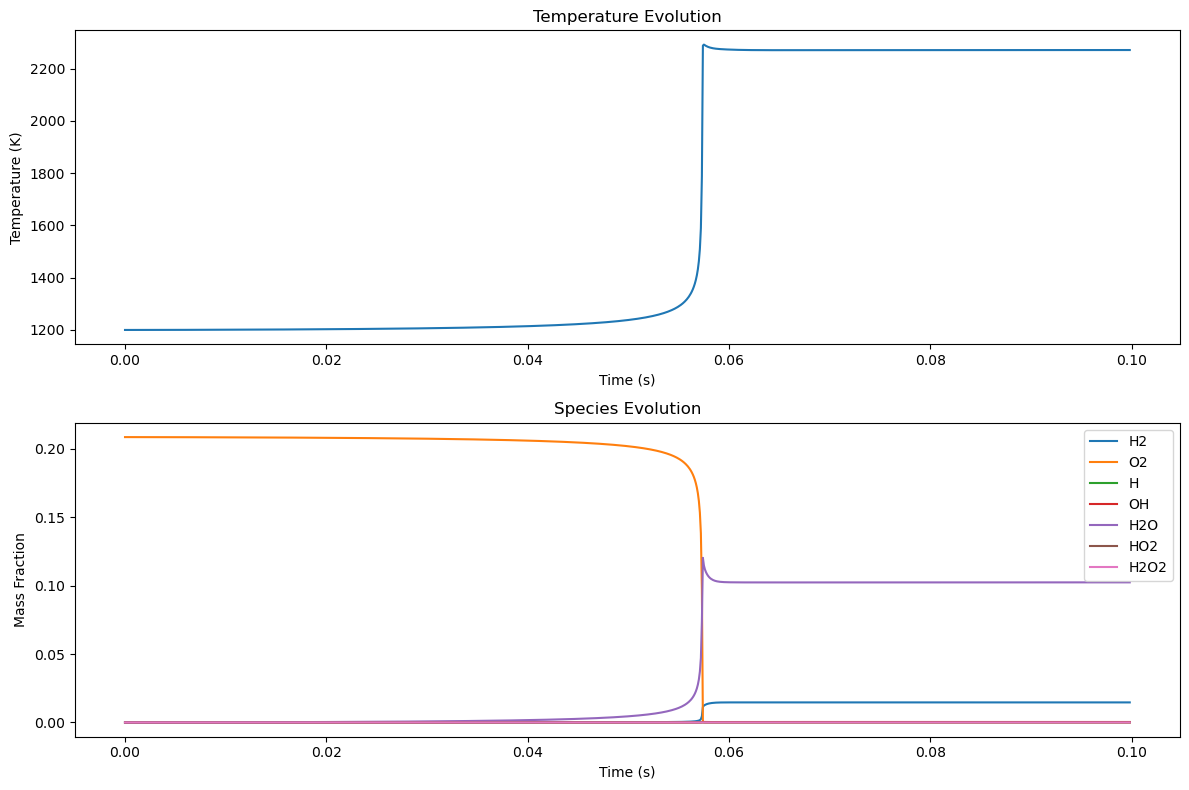

In [39]:
env.problem.plot_reference_solution()

In [40]:
eval_path =f"pretraining_results/{time.strftime('%Y%m%d_%H%M%S')}/custom_evaluation"
os.makedirs(eval_path, exist_ok=True)

model_results = run_episode_with_tracking(
    env=env_model,
    agent=agent,
    fixed_action=None,
    timeout=env_args.timeout,
    render_path=f"{eval_path}/model_run"
)

action0_results = run_episode_with_tracking(
    env=env_model,
    agent=agent,
    fixed_action=0,
    timeout=env_args.timeout,
    render_path=f"{eval_path}/action0_run"
)

action1_results = run_episode_with_tracking(
    env=env_model,
    agent=agent,
    fixed_action=1,
    timeout=env_args.timeout,
    render_path=f"{eval_path}/action1_run"
)



Running episode with trained model
Predicted action: 0 - time: 0.00435638427734375
Step 0 of 1 - Action Distribution: {0: 1, 1: 0} - cpu time: 0.0007097721099853516 - error: 1.797951544313392e-07 - max temperature: 1300.0
Predicted action: 0 - time: 0.008420944213867188
Predicted action: 0 - time: 0.005810737609863281
Predicted action: 0 - time: 0.0037441253662109375
Predicted action: 0 - time: 0.006056070327758789
Predicted action: 0 - time: 0.0037381649017333984
Predicted action: 0 - time: 0.0026793479919433594
Predicted action: 0 - time: 0.004111766815185547
Predicted action: 0 - time: 0.003659963607788086
Predicted action: 0 - time: 0.002153158187866211
Predicted action: 0 - time: 0.0014224052429199219
Step 10 of 11 - Action Distribution: {0: 11, 1: 0} - cpu time: 0.004712104797363281 - error: 2.5783466330864258e-06 - max temperature: 1300.0
Predicted action: 0 - time: 0.0014586448669433594
Predicted action: 0 - time: 0.001018524169921875
Predicted action: 0 - time: 0.0033073425292

In [41]:
# # compare the cpu times, temperatures, and action history in a 3 x 1 plot
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0,0].plot(action0_results['history']['cpu_times'], label='RK23')
axs[0,0].plot(action1_results['history']['cpu_times'], label='BDF')
axs[0,0].plot(model_results['history']['cpu_times'], label='model', linestyle='--')
axs[0,0].legend()
axs[0,0].set_title('CPU Time')


axs[0,1].plot(action0_results['history']['temperatures'], label='RK23')
axs[0,1].plot(action1_results['history']['temperatures'], label='BDF')
axs[0,1].plot(model_results['history']['temperatures'], label='model', linestyle='--')
axs[0,1].legend()
axs[0,1].set_title('Temperature')


axs[1,0].plot(action0_results['action_history'], label='RK23')
axs[1,0].plot(action1_results['action_history'], label='BDF')
axs[1,0].plot(model_results['action_history'], label='model', linestyle='--')
axs[1,0].legend()
axs[1,0].set_title('Action History')
plt.savefig(f"{eval_path}/action_history.png")
plt.close()

# plot a bar chart of the total cpu time and total error for each action
fig, axs = plt.subplots(2, 1, figsize=(10, 8), dpi=300)
methods = ['RK23', 'BDF', 'model']
cpu_times = [action0_results['total_cpu_time'], action1_results['total_cpu_time'], model_results['total_cpu_time']]
errors = [action0_results['total_error'], action1_results['total_error'], model_results['total_error']]
axs[0].bar(methods, cpu_times)
axs[0].set_title('Total CPU Time')
axs[1].bar(methods, errors)
axs[1].set_title('Total Error')
plt.savefig(f"{eval_path}/total_cpu_time_and_error.png")
plt.close()

